In [10]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
def load_data():
    confirmed_df = pd.read_csv(
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv(
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    return confirmed_df, deaths_df

confirmed_df, deaths_df = load_data()

In [13]:
confirmed = confirmed_df.iloc[:, 4:]
deaths = deaths_df.iloc[:, 4:]
dates = confirmed.columns

world_cases = confirmed.sum(axis=0).values
total_deaths = deaths.sum(axis=0).values
mortality_rate = total_deaths / world_cases


In [14]:
def daily_increase(data):
    return [data[i] - data[i-1] if i != 0 else data[0] for i in range(len(data))]

def moving_average(data, window=7):
    return [np.mean(data[i:i+window]) if i + window < len(data) else np.mean(data[i:]) for i in range(len(data))]

In [15]:
world_daily_cases = daily_increase(world_cases)
world_daily_deaths = daily_increase(total_deaths) 

2025-05-02 02:22:42.094 
  command:

    streamlit run c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

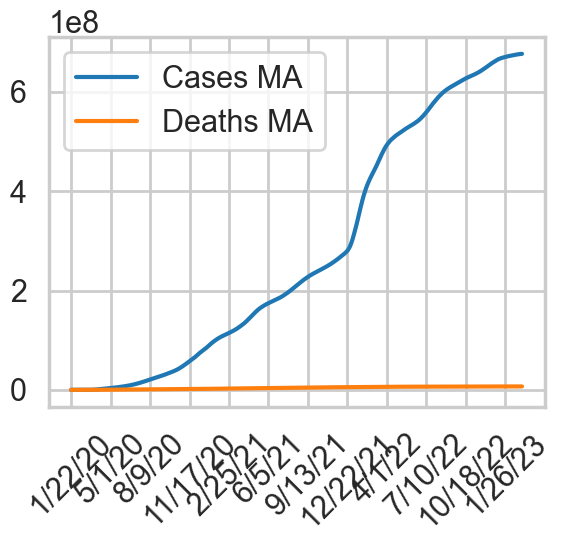

In [16]:
st.title("COVID-19 Multi-Country Time Series Visualizer")
st.markdown("This dashboard visualizes COVID-19 confirmed cases, deaths, and predictions using multiple models.")

window_size = st.slider("Rolling Average Window", 3, 14, 7)
days_to_forecast = st.slider("Days to Forecast", 7, 30, 10)

st.subheader("Rolling Averages")
fig, ax = plt.subplots()
ax.plot(dates, moving_average(world_cases, window_size), label='Cases MA')
ax.plot(dates, moving_average(total_deaths, window_size), label='Deaths MA')
ax.set_xticks(dates[::100])
ax.legend()
plt.xticks(rotation=45)
st.pyplot(fig)

In [17]:
X = np.array(range(len(dates))).reshape(-1, 1)
y = np.array(world_cases).reshape(-1, 1)
future_X = np.array(range(len(dates) + days_to_forecast)).reshape(-1, 1)
adjusted_dates = future_X[:-days_to_forecast]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.07)

In [18]:
# Polynomial Regression
poly = PolynomialFeatures(degree=3)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
X_poly_future = poly.transform(future_X)


In [19]:
linear_model = LinearRegression()
linear_model.fit(X_poly_train, y_train)
poly_preds = linear_model.predict(X_poly_future)

In [20]:
# Bayesian Ridge
bayesian = BayesianRidge()
bayesian.fit(X_poly_train, y_train)
bayes_preds = bayesian.predict(X_poly_future)

In [21]:
# SVR
svr = SVR(kernel='poly', C=0.1, gamma=0.01, epsilon=1, degree=3)
svr.fit(X_train, y_train.ravel())
svr_preds = svr.predict(future_X)

In [22]:
model = st.selectbox("Select Model", ["Polynomial Regression", "Bayesian Ridge", "SVR"])

st.subheader("Prediction vs Real Data")
fig2, ax2 = plt.subplots()
ax2.plot(dates, world_cases, label='Actual Cases')
if model == "Polynomial Regression":
    ax2.plot(future_X, poly_preds, label='Polynomial Forecast')
elif model == "Bayesian Ridge":
    ax2.plot(future_X, bayes_preds, label='Bayesian Forecast')
else:
    ax2.plot(future_X, svr_preds, label='SVR Forecast')

ax2.axvline(x=len(dates), color='red', linestyle='--')
ax2.legend()
st.pyplot(fig2)

2025-05-02 02:24:02.293 Session state does not function when running a script without `streamlit run`


DeltaGenerator()

In [23]:
st.subheader("Dual Y-Axis Plot: Active vs Total Cases")
fig3, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(dates, world_cases, color='blue', label='Total Cases')
ax4.plot(dates, world_daily_cases, color='green', label='Daily Increase')
ax3.set_xlabel('Date')
ax3.set_ylabel('Total Cases', color='blue')
ax4.set_ylabel('Daily Increase', color='green')
fig3.autofmt_xdate()
st.pyplot(fig3)

DeltaGenerator()

In [25]:
st.subheader("Peak Annotations")
peak_cases = np.argmax(world_daily_cases)
peak_date = dates[peak_cases]
st.markdown(f"**Peak Daily Cases:** {world_daily_cases[peak_cases]} on {peak_date}")

peak_deaths = np.argmax(world_daily_deaths)
peak_death_date = dates[peak_deaths]
st.markdown(f"**Peak Daily Deaths:** {world_daily_deaths[peak_deaths]} on {confirmed.columns[peak_deaths]}")


DeltaGenerator()